# Architecture
1. Model from Roboflow to detect if there are traffic signs in the image (detects a traffic sign, the image will be cropped and the cropped image will be classified by the ResNet50 model)
1. Self trained model to detect the type of the traffic sign (ResNet50)
1. YoloV8n to detect everything else
1. If Yolo detects traffic lights use another self trained model to detect the type of the traffic light

## Usage
First we define all variables and create the necessary models and methods.


In [9]:
%%capture
# Use code from other notebook
%run ./traffic-signs-recognition-resnet-from-scratch.ipynb

In [2]:
import custom_utils as cu
from ultralytics import YOLO
import cv2
import tensorflow as tf
from keras.models import load_model
import numpy as np

In [3]:
import os
from dotenv import load_dotenv

# Load .env files
load_dotenv()

# Get environment variables
dataset_dir = os.getenv('DATASET_DIR')
input_data = os.path.join(dataset_dir, 'test_data')

In [4]:
# Load images
image_paths, images = cu.get_images(input_data)

# First model to detect if there are traffic signs in the image

In [5]:
from roboflow import Roboflow
import json

rf = Roboflow(api_key="xqA88kI3SpGCI49QTYmU")
project = rf.workspace().project("traffic-sign-detection-yolov8")
model_traffic_sign_detection = project.version(3).model

# Test the model
path = os.path.join(dataset_dir, "test_data/test1.jpg")

# infer on a local image
predict = model_traffic_sign_detection.predict(path, confidence=40, overlap=30)
predict.save("prediction.jpg")
res = predict.json()
print(json.dumps(res, indent=1))

loading Roboflow workspace...
loading Roboflow project...
{
 "predictions": [
  {
   "x": 244.0,
   "y": 139.0,
   "width": 32.0,
   "height": 40.0,
   "confidence": 0.8194526433944702,
   "class": "traffic-signs",
   "image_path": "/home/a-schulz/Projects/aai-selfdriving-cars/dataset/test_data/test1.jpg",
   "prediction_type": "ObjectDetectionModel"
  },
  {
   "x": 419.5,
   "y": 70.0,
   "width": 63.0,
   "height": 72.0,
   "confidence": 0.7951635718345642,
   "class": "traffic-signs",
   "image_path": "/home/a-schulz/Projects/aai-selfdriving-cars/dataset/test_data/test1.jpg",
   "prediction_type": "ObjectDetectionModel"
  },
  {
   "x": 494.0,
   "y": 184.5,
   "width": 84.0,
   "height": 99.0,
   "confidence": 0.579341471195221,
   "class": "traffic-signs",
   "image_path": "/home/a-schulz/Projects/aai-selfdriving-cars/dataset/test_data/test1.jpg",
   "prediction_type": "ObjectDetectionModel"
  },
  {
   "x": 484.5,
   "y": 42.0,
   "width": 79.0,
   "height": 66.0,
   "confidence

# Extract Cropped Images from Predictions JSON.
    
    This function takes predictions generated from object detection and extracts cropped images based on the predictions.
    
    Args:
        res (dict): A dictionary containing predictions, typically generated from an object detection model.
        increase_box (float, optional): A factor by which to increase the bounding box size (default: 1.25).
        
    Returns:
        list: A list containing PIL Image objects representing the cropped regions of interest.
    

In [6]:
from PIL import Image
def get_cropped_images(res, increase_box=1.25):
    '''
    Get the cropped images from the predictions json.
    @param res: 
    @param increase_box: 
    @return: images[]
    '''
    cropped_images = []
    for i in res['predictions']:
        if i['class'] != 'traffic-signs':
            continue
        # Load the image
        image_path = i['image_path']
        image = Image.open(image_path)

        # Get the prediction details
        x = i['x']
        y = i['y']
        width = i['width'] * increase_box
        height = i['height'] * increase_box

        # Extract the region of interest from the image
        roi = image.crop((x - width / 2, y - height / 2, x + width / 2, y + height / 2))
        cropped_images.append(roi)
    return cropped_images

# Plot Cropped Images in a Grid.

    This function takes an array of cropped images and plots them in a grid layout. The number of rows and columns
    in the grid is calculated to best fit the images.

    Args:
        image_array (list): A list of PIL Image objects to be plotted.

    Returns:
        None

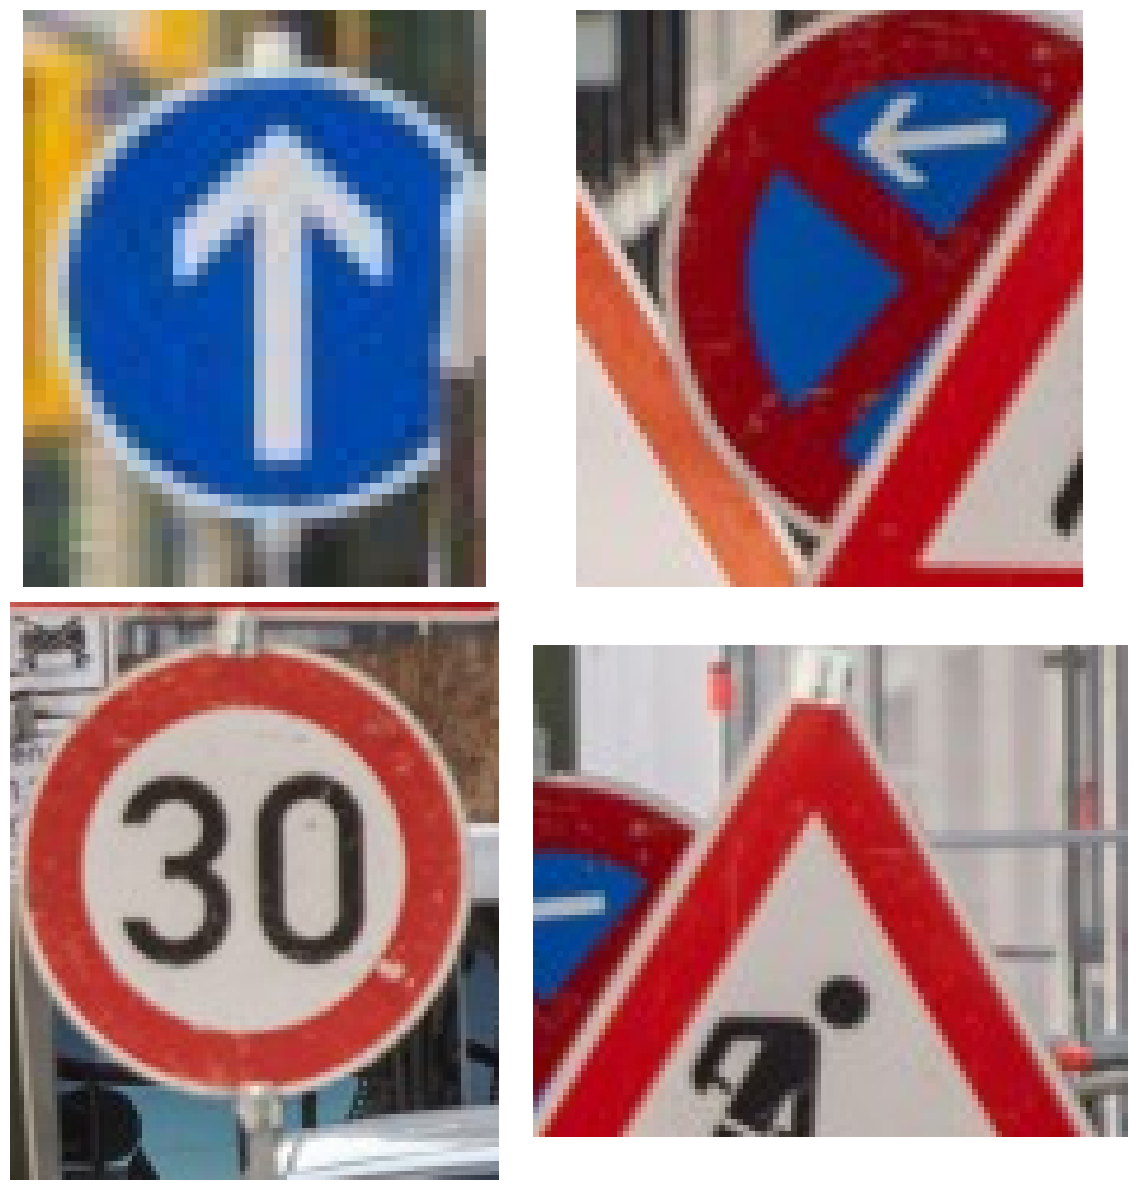

In [7]:
import matplotlib.pyplot as plt

image_array = get_cropped_images(res)

def plot_images(image_array):
    num_images = len(image_array)
    num_rows = int(num_images ** 0.5)
    num_cols = (num_images + num_rows - 1) // num_rows
    
    # Create a subplot grid
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))
    
    # Flatten the axes array if needed
    axes = axes.flatten()
    
    # Plot each image
    for i, ax in enumerate(axes):
        if i < num_images:
            ax.imshow(image_array[i])
            ax.axis('off')  # Turn off axis labels
        else:
            ax.axis('off')  # Turn off unused subplots
    
    # Show the plot
    plt.tight_layout()
    plt.show()
plot_images(image_array)

# Second model to detect the type of the traffic sign

In [16]:
import torch

model_traffic_sign_classification = ResNet50(img_channel=3, num_classes=43)
model_weights = os.path.join(os.getcwd(), "traffic_sign_model/best_model.pt")
model_traffic_sign_classification.load_state_dict(torch.load(model_weights))
model_traffic_sign_classification.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): block(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    

# Create a Preprocessing Pipeline

This code snippet creates a preprocessing pipeline using the torchvision.transforms module. The pipeline applies a series of transformations to input images, preparing them for use in a neural network.

## The pipeline includes the following transformations:
1. Resize: Resizes the input image to a size of 256x256 pixels, maintaining aspect ratio.
2. CenterCrop: Crops the center of the resized image to a size of 224x224 pixels, often used for input to neural networks.
3. ToTensor: Converts the image to a PyTorch tensor, allowing it to be used as input to a neural network.
4. Normalize: Applies normalization to the image tensor. This involves subtracting the specified mean values and dividing by the specified standard deviation values for each channel.

## Transform Parameters:
- Resize: The image is resized to a square of size 256x256 pixels.
- CenterCrop: The center of the resized image is cropped to 224x224 pixels.
- ToTensor: Converts the image to a tensor, changing the data type to float and scaling pixel values to the range [0, 1].
- Normalize: Normalizes the tensor's pixel values using the provided mean and standard deviation values for each channel.

# Usage Example:
transformed_image = preprocess(original_image)

Here, 'original_image' is a PIL Image object, and 'transformed_image' is a processed tensor suitable for feeding into a neural network.

In [11]:
from torchvision import transforms
# Create a preprocessing pipeline
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )])

# Load CSV Data as a Dictionary

This code snippet reads a CSV file and converts its content into a dictionary format.

## Function:
- The 'load_csv_as_dict' function is called and expects the path to a CSV file as an argument.
- The CSV file is opened and its content is processed line by line.
- The first line (header) is skipped.
- For each line, the values of the first two columns are stored as a key-value pair in the 'result' dictionary.

## Arguments:
- file_path (str): The path to the CSV file to be loaded.

## Return Value:
- dict: A dictionary containing data from the CSV file. The first column is used as keys and the second column as values.

## Example Usage:
- The example demonstrates how to use the 'load_csv_as_dict' function to load data from a CSV file and store it in the 'labels' dictionary.


In [12]:
import csv

def load_csv_as_dict(file_path):
    result = {}

    with open(file_path, 'r') as csv_file:
        csv_reader = csv.reader(csv_file)
        next(csv_reader)  # Skip the header
        for row in csv_reader:
            if len(row) >= 2:
                result[row[0]] = row[1]

    return result

labels = load_csv_as_dict(os.path.join(os.getcwd(), "traffic_sign_model/classid_label.csv"))

# Test the Model

This code snippet demonstrates how to use a trained traffic sign classification model to make predictions on an input image.

## Steps:
1. Import the necessary modules.
2. Define the path to the input image file.
3. Open the image using the PIL library and convert it to RGB mode.
4. Preprocess the image using a preprocessing pipeline.
5. Expand the dimensions of the image tensor to create a batch-like structure.
6. Set the model to evaluation mode using the 'eval()' method.
7. Feed the preprocessed image tensor into the model to obtain predictions.
8. Use the 'torch.max()' function to get the index of the predicted class.
9. Print the predicted traffic sign label using the 'labels' dictionary.

## Important Variables and Functions:
- path: The path to the input image file.
- img: The preprocessed image tensor.
- model_traffic_sign_classification: The trained traffic sign classification model.
- labels: The dictionary containing traffic sign labels.

## Usage Notes:
- This code assumes that 'dataset_dir' points to the directory containing the dataset and 'preprocess' is the preprocessing pipeline as explained in the previous documentation.
- The 'model_traffic_sign_classification' should be loaded with a trained traffic sign classification model.
- The 'labels' dictionary should contain class labels corresponding to class indices.

## Example Output:
- The code prints the predicted label of the traffic sign in the provided input image.

## Note:
- The 'torch' library is required for the code to work properly.


In [22]:
from PIL import Image
# Test the model
path = os.path.join(dataset_dir, "test_data/test1.jpg")
img = Image.open(path).convert("RGB")
img = preprocess(img)
img = img.unsqueeze(0)
model_traffic_sign_classification.eval()
res = model_traffic_sign_classification(img)
_, index = torch.max(res, 1)
print(labels[str(int(index[0]))])

traffic circle


## YoloV8n to detect everything else

In [ ]:
# Load a model(s)
model = YOLO('yolov8n.pt')

In [ ]:
# Run batched inference on a list of images
# results get saved in runs/detect folder 
results = model.predict(images, save=True, save_txt=True)  # return a list of Results objects

# Plot Image for Debugging (Not Necessary)

This code snippet demonstrates a debugging technique that allows you to visualize a sequence of images and navigate through them interactively.

## Steps:
- Initialize the index 'i' to 0.
- Enter a loop that displays an image using OpenCV's 'cv2.imshow()' function.
- The loop waits for a key press using 'cv2.waitKey(0)'.
- If the key pressed is '0', the loop breaks, effectively ending the debug session.
- If the key pressed is '1', the index 'i' is incremented to visualize the next image.
- Close any open OpenCV windows using 'cv2.destroyAllWindows()' at the end of the loop.

## Usage:
- Use this code snippet when you want to interactively view a sequence of images while debugging your code.

## Note:
- This code assumes that 'res' is a list of images that you want to visualize.
- This code uses the OpenCV library ('cv2') for image display and key capture.
- Press the '0' key to exit the debugging session.
- Press the '1' key to navigate to the next image.
- Make sure to include appropriate logic to handle the size of 'res' and avoid index out of range errors.


In [ ]:
# plot image for debug not necessary 
i = 0
while i < len(res):
    cv2.imshow("Hi", res[i])
    key = cv2.waitKey(0)

    if key == ord("0"):
        break
    elif key == ord("1"):
        i += 1

    cv2.destroyAllWindows()

In [ ]:
# should be append by traffic sign
light_model = load_model("traffic_light_model.keras")

In [ ]:
predicted = light_model.predict(res)

## Output Traffic Light Detection Results

This code snippet displays the results of traffic light detection, showing images of traffic lights and their corresponding predicted labels.

# Steps:
1. Print the 'predicted' array, which likely contains predicted labels for traffic light states.
2. Initialize the index 'i' to 0.
3. Create a list 'labels' containing traffic light state labels (e.g., "green", "none", "red", "yellow").
4. Enter a loop that displays images using OpenCV's 'cv2.imshow()' function.
5. The loop waits for a key press using 'cv2.waitKey(0)'.
6. If the key pressed is '0', the loop breaks, ending the visualization.
7. If the key pressed is '1', the index 'i' is incremented to visualize the next image.
8. Close any open OpenCV windows using 'cv2.destroyAllWindows()' at the end of the loop.

# Usage:
- Use this code snippet when you want to visualize the results of traffic light detection.
- The 'predicted' array should contain predicted labels for traffic light states.
- Make sure to include appropriate logic to handle the size of 'predicted' and avoid index out of range errors.

# Note:
- This code uses the OpenCV library ('cv2') for image display and key capture.
- The 'labels' list should be consistent with the predicted label order in the 'predicted' array.
- Press the '0' key to exit the visualization.
- Press the '1' key to navigate to the next image.


In [ ]:
# Out put traffic light detection
print(predicted)
i = 0
labels = ["green", "none", "red", "yellow"]
while i < predicted.shape[0]:
    cv2.imshow(labels[np.argmax(predicted[i])], res[i])
    key = cv2.waitKey(0)

    if key == ord("0"):
        break
    elif key == ord("1"):
        i += 1

    cv2.destroyAllWindows()

## Traffic light detection - specific

# Everything together

# Detect and Record Object Information in Images

This code snippet processes a list of images, detecting and recording information about traffic signs, traffic lights, and other objects present in each image.

## Steps:
1. Initialize an empty dictionary 'results' to store the detected object information for each image.
2. Iterate through the images using 'enumerate(image_paths)'.
3. For each image, create a sub-dictionary structure within 'results' to store information about traffic signs, traffic lights, and other objects.
4. Use the 'model_traffic_sign_detection' to predict traffic signs in the image with specified confidence and overlap parameters.
5. If traffic signs are detected, crop and preprocess the images, then use 'model_traffic_sign_classification' to classify the traffic sign types and add them to the 'traffic signs' list in 'results'.
6. To-do: Comment suggests future work to improve traffic sign type detection accuracy.
7. Detect other objects (to be implemented based on your requirements).
8. If there is a traffic light detected, use a similar approach to detect the traffic light type.
9. Print the final 'results' dictionary containing detected object information.

## Usage Notes:
- This code assumes that you have 'image_paths' as a list of image file paths.
- 'model_traffic_sign_detection' is used for traffic sign detection, and 'model_traffic_sign_classification' is used for traffic sign type classification.
- The 'get_cropped_images' and 'plot_images' functions are used for preprocessing and visualization, respectively.

Note:
- This code serves as a template and might need additional implementation for detecting other objects and traffic light types.


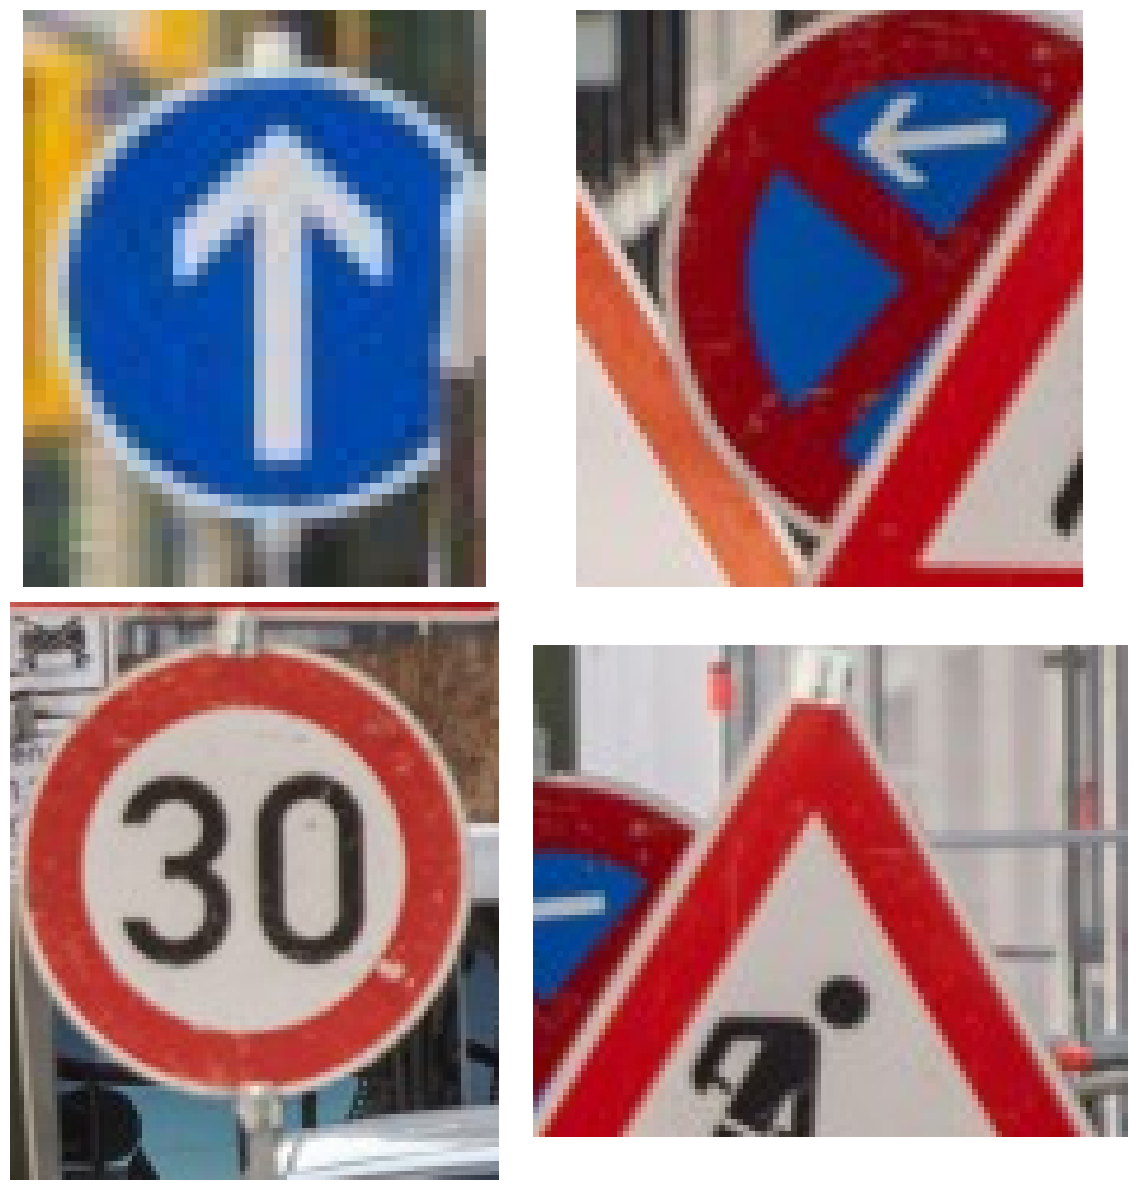

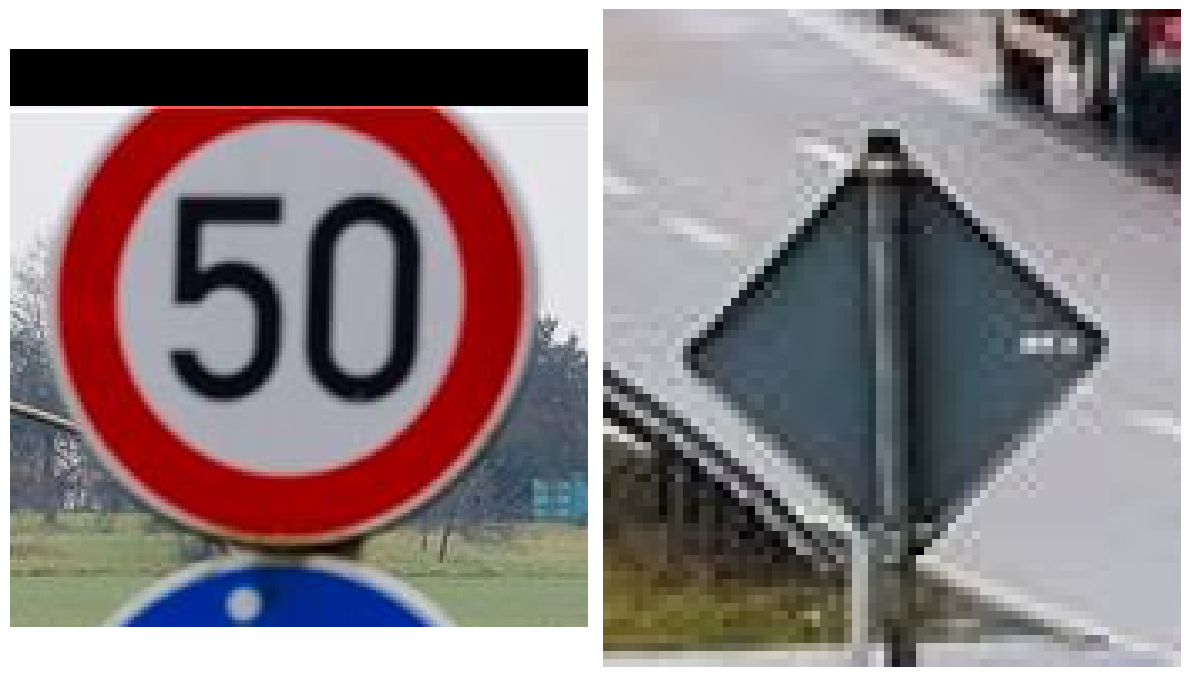

{0: {'traffic signs': ['traffic circle', '80 km/h', 'traffic circle', '120 km/h'], 'traffic lights': [], 'other objects': []}, 1: {'traffic signs': ['120 km/h', 'give way'], 'traffic lights': [], 'other objects': []}}


In [25]:
results = {}
for image_index, image in enumerate(image_paths):
    results[image_index] = {"traffic signs": [], "traffic lights": [], "other objects": []}
    # Detect traffic signs
    res = model_traffic_sign_detection.predict(image, confidence=40, overlap=30).json()
    if len(res['predictions']) != 0:
        # Detect traffic sign type
        # ToDo: Accuracy is pretty low
        cropped_images = get_cropped_images(res)
        plot_images(cropped_images)
        for image in cropped_images:
            img = preprocess(image)
            img = img.unsqueeze(0)
            res = model_traffic_sign_classification(img)
            _, index = torch.max(res, 1)
            results[image_index]["traffic signs"].append(labels[str(int(index[0]))])
    # Detect other objects
    # if there is a trafficlight
        # Detect traffic light type  
print(results)

# Print the results

In [ ]:
# plot
# print

# Some statistics